# From Cloudy to Clarity: Probabilistic Air Pollution Forecasting Using Mixture Density Networks

Capstone Team 3:
- Francis Mark Cayco
- Andgrel Heber Jison
- Angela Elaine Pelayo
- Eros Paul Estante

**Machine Learning 3**

Masters of Science in Data Science

Asian Institute of Management


## Abstract
Air pollution forecasting is inherently uncertain due to the complex, dynamic nature of environmental factors. Traditional point forecasting models fail to capture this uncertainty, often providing inaccurate or misleading predictions during extreme events. In this study, we propose a probabilistic forecasting framework based on Mixture Density Networks (MDNs) integrated with various sequential architectures, including RNN, GRU, LSTM, TCN, and Transformer models. Our results show that GRU-MDN achieves the best overall performance, with the lowest validation loss (–4.73) and strong generalization capabilities. In contrast, TCN-MDN, while achieving the lowest training loss, exhibits severe overfitting, and Transformer-MDN underperforms due to slower convergence and potential underfitting. We further demonstrate that the GRU-MDN model produces well-calibrated predictive distributions, with uncertainty intervals that effectively capture temporal variability in pollutants such as CO and NO. These results highlight the benefits of probabilistic modeling in environmental forecasting, enabling risk-aware decision-making and improved interpretability over deterministic approaches.

## Problem Statement
*How can Mixture Density Networks improve air pollution forecasting by providing uncertainty-aware predictions that support more informed and reliable business or policy decisions?*

Traditional air quality forecasting models frequently provide deterministic, single-point predictions without quantifying the associated uncertainty. This limitation can be problematic, especially when decision-making requires an understanding of the range of possible outcomes. Recent studies have highlighted this issue. For instance, research has shown that most current data-driven air quality forecasting solutions lack proper quantifications of model uncertainty, which is crucial for communicating the confidence in forecasts. This gap underscores the need for models that can provide probabilistic forecasts, offering a distribution of possible outcomes rather than a single deterministic prediction.

Incorporating uncertainty quantification into air quality forecasts allows for better risk assessment and more informed decision-making. Probabilistic models, such as those using deep learning techniques, have been developed to address this need, providing more reliable uncertainty estimates and improving the practical applicability of air quality forecasts.

## Purpose
The goal of this project is to develop a probabilistic air quality forecasting model that captures a full range of possible pollutant concentrations, rather than relying on single-point predictions.  Use Mixture Density Networks (MDNs) to model predictive uncertainty.


Train and evaluate the MDN framework using various sequence modeling architectures:
- LSTM-MDN
- GRU-MDN
- Classic RNN-MDN
- TCN-MDN
- Transformer-MDN


## Data Source
This project uses air quality index (AQI) data sourced from the OpenWeatherMap API, covering 138 cities globally from 2023 to 2025. For consistency and regional focus, we limit the scope to cities within Metro Manila, Philippines. The dataset contains hourly measurements of seven key air pollutants: sulfur dioxide (SO₂), nitrogen dioxide (NO₂), particulate matter (PM10 and PM2.5), ozone (O₃), and carbon monoxide (CO). These pollutants are commonly monitored in environmental health studies and serve as the prediction targets for our probabilistic forecasting models.

## Setting Up
If you wish to run this notebook:
1. Create and activate new conda environment with the following command:
```bash
conda env create -f environment.yml
```


In [ ]:
import glob
import os
import time
import math
import hashlib
import json
import pickle
from pathlib import Path
import warnings 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
import imageio
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import optuna

from src.constants import (
    DATASET_DIR,
    CACHE_DIR,
    MODELS_DIR,
    TQDM_DISABLE,
    CITY_NAMES,
    POLLUTANT_COLUMNS,
)

In [ ]:
import torch

print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

In [ ]:
ENABLE_TRAINING = True

## Loading the Data

In [ ]:
DATASET_DIR

In [ ]:
dfs = []
for file in (pbar := tqdm(glob.glob(str(DATASET_DIR / "raw" / "aqi" / "*" / "*.csv")))):
    pbar.set_description(f"Reading {file}")
    df = pd.read_csv(file)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


In [ ]:
df = df[df['city_name'].isin(CITY_NAMES)]
df = df[["datetime","components.co","components.no","components.no2","components.o3","components.so2","components.pm2_5","components.pm10","components.nh3","city_name"]]
df.sort_values(by=['city_name', 'datetime'], inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.round('h')
df.head()

## Data Preprocessing

Perform data interpolation to satisfy the hourly frequency requirement. `city_name` is one hot encoded for the model.

In [ ]:
filled_dfs = []
for city, group in tqdm(df.groupby('city_name')):
    group = group.set_index('datetime')
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq='h')
    group = group.groupby(level=0).mean(numeric_only=True)
    group = group.reindex(full_index)
    
    group.interpolate(method='linear', inplace=True)
    group['city_name'] = city  # Re-add city name after reindex
    filled_dfs.append(group)

filled_dfs = pd.concat(filled_dfs)

In [ ]:
city_column = filled_dfs['city_name'].copy()
dataset_df = pd.get_dummies(filled_dfs, prefix='city',dtype=np.int8)
dataset_df["city_name"] = city_column
dataset_df

## Calcualting Baseline for the Dataset

As a baseline, we compute the negative log-likelihood (NLL) under a single Gaussian distribution fitted to the entire training dataset. This Gaussian has a fixed mean and standard deviation equal to the empirical mean and standard deviation of the target variable. The baseline NLL represents the performance of a model that ignores all input features and simply assumes that the target values follow a constant distribution.

In [ ]:
nlls = []
for city_name, group in dataset_df.groupby('city_name'):
    group = group.copy()
    y = group.drop(columns=['city_name'])[POLLUTANT_COLUMNS]
    y = torch.tensor(y.values, dtype=torch.float32)
    mu = y.mean()
    sigma = y.std()

    eps = 1e-6
    sigma = torch.clamp(sigma, min=eps)
    z = (y - mu) / sigma

    log_prob = -0.5 * 7 * math.log(2 * math.pi) - torch.sum(torch.log(sigma)) - 0.5 * torch.sum(z ** 2, dim=1)
    nll = -log_prob.mean()

    nlls.append(nll.item())

print(f"Average Negative Log Likelihood for all cities: {np.average(nlls):.4f}", )

## Define the Dataset Class

In [ ]:
class AQIDataset(Dataset):
    def __init__(self, data, lookback, delay, min_index, max_index, step, mean, std):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.min_index = min_index
        self.max_index = min(max_index if max_index is not None else len(data) - delay - 1,
                             len(data) - delay - 1)
        self.step = step
        self.mean = mean
        self.std = std

        param_str = f"{self._data_hash()}_lb{lookback}_d{delay}_min{min_index}_max{self.max_index}_s{step}"
        samples_path = os.path.join(CACHE_DIR, f"{param_str}_samples.pt")
        targets_path = os.path.join(CACHE_DIR, f"{param_str}_targets.pt")
        metadata_path = os.path.join(CACHE_DIR, f"{param_str}_metadata.pkl")

        if all(os.path.exists(p) for p in [samples_path, targets_path, metadata_path]):
            self.samples = torch.load(samples_path)
            self.targets = torch.load(targets_path)

            with open(metadata_path, "rb") as f:
                metadata = pickle.load(f)
            self._timestamps = metadata["timestamps"]
            self.mean = metadata["mean"]
            self.std = metadata["std"]
        else:
            samples, targets, timestamps = [], [], []

            for idx in (pbar := tqdm(range(self.__len__()), disable=True)):
                i = self.min_index + idx + self.lookback
                indices = range(i - self.lookback, i, self.step)

                sample = self.data.iloc[indices].values  # shape: (lookback, num_features)
                target_row = self.data.iloc[i + self.delay]

                target = target_row[POLLUTANT_COLUMNS].values.astype(np.float32)
                samples.append(sample)
                targets.append(target)
                timestamps.append(pd.to_datetime(target_row.name))

            self.samples = torch.tensor(np.array(samples), dtype=torch.float32)
            self.targets = torch.tensor(np.array(targets), dtype=torch.float32)
            self._timestamps = timestamps

            torch.save(self.samples, samples_path)
            torch.save(self.targets, targets_path)
            with open(metadata_path, "wb") as f:
                pickle.dump({
                    "timestamps": self._timestamps,
                    "mean": self.mean,
                    "std": self.std
                }, f)

    def _data_hash(self) -> str:
        content_hash = pd.util.hash_pandas_object(self.data, index=True).values
        combined = content_hash.tobytes()
        return hashlib.md5(combined).hexdigest()

    def __len__(self):
        return self.max_index - self.min_index - self.lookback + 1

    def __getitem__(self, index):
        return self.samples[index], self.targets[index]

    def get_metadata(self, index: int):
        normalized_target = self.targets[index].numpy()
        original_target = normalized_target * self.std + self.mean
        return {
            "timestamp": self._timestamps[index],
            "original_target": original_target,
            "mean": self.mean,
            "std": self.std,
        }

class ConcatDatasetWithMetadata(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self._offsets = self._compute_offsets()

    def _compute_offsets(self):
        offsets = []
        offset = 0
        for d in self.datasets:
            offsets.append(offset)
            offset += len(d)
        return offsets

    def get_metadata(self, index: int):
        for i in range(len(self.datasets)):
            if index < self._offsets[i] + len(self.datasets[i]):
                local_index = index - self._offsets[i]
                return self.datasets[i].get_metadata(local_index)
        raise IndexError("Index out of range for get_metadata in ConcatDatasetWithMetadata.")

Helper function to generate datasets.  Train test split is defined in this function wherein the validation set is the last 1 year of the dataset.  Data normalization through standardization is also performed in this function.

In [ ]:
def generate_datasets(dataset_df : pd.DataFrame, lookback=96, delay=24, step=1):
    training_datasets = []
    validation_datasets = []
    for city, group in (pbar := tqdm(dataset_df.groupby("city_name"))):
        pbar.set_description(f"Processing {city}")
        group.sort_index(ascending=True, inplace=True)

        last_index = group.index[-1]
        one_year_ago = last_index - pd.DateOffset(months=6)
        min_index = group.index.get_loc(one_year_ago)

        group.drop(columns=["city_name"], inplace=True)
        training_df = group.iloc[:min_index].copy()
        validation_df = group.iloc[min_index:].copy()

        training_mean = training_df[POLLUTANT_COLUMNS].mean()
        training_std = training_df[POLLUTANT_COLUMNS].std()

        training_df[POLLUTANT_COLUMNS] = (training_df[POLLUTANT_COLUMNS] - training_mean) / training_std
        validation_df[POLLUTANT_COLUMNS] = (validation_df[POLLUTANT_COLUMNS] - training_mean) / training_std

        training_dataset = AQIDataset(
            training_df,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=step,
            mean=training_mean,
            std=training_std,
        )

        validation_dataset = AQIDataset(
            validation_df,
            lookback=lookback,
            delay=delay,
            min_index=0,
            max_index=None,
            step=step,
            mean=training_mean,
            std=training_std,
        )

        training_datasets.append(training_dataset)
        validation_datasets.append(validation_dataset)

    training_dataset = ConcatDatasetWithMetadata(training_datasets)
    validation_dataset = ConcatDatasetWithMetadata(validation_datasets)

    return training_dataset, validation_dataset
    return training_datasets[0], validation_dataset[0]

## The Mixture Density Network (MDN) Framework
Traditional neural networks often predict a single outcome, which may not capture the inherent uncertainty in many real-world scenarios. MDNs address this by modeling the output as a mixture of multiple probability distributions, typically Gaussians, allowing the network to represent multiple plausible outcomes for a given input.
- Mixture of Gaussians: Instead of outputting a single prediction, MDNs output parameters for multiple Gaussian distributions (means, variances, and mixing coefficients), effectively modeling a probability distribution over possible outcomes.
- Handling Uncertainty: This approach is particularly useful in situations where the data is noisy or where multiple outcomes are possible, such as in time series forecasting or trajectory prediction.
- Training with NLL: MDNs are trained using the Negative Log-Likelihood (NLL) loss function, which encourages the model to assign high probabilities to the actual observed outcomes.


MDNs are well-suited for tasks that involve uncertainty and multiple possible outcomes, including:
- Time Series Forecasting: Predicting future values in a sequence where multiple future paths are possible.
- Trajectory Prediction: Estimating the future positions of moving objects, such as pedestrians or vehicles, where multiple paths may be plausible.
- Air Quality Forecasting: Modeling pollutant concentrations where various factors contribute to uncertainty in predictions.

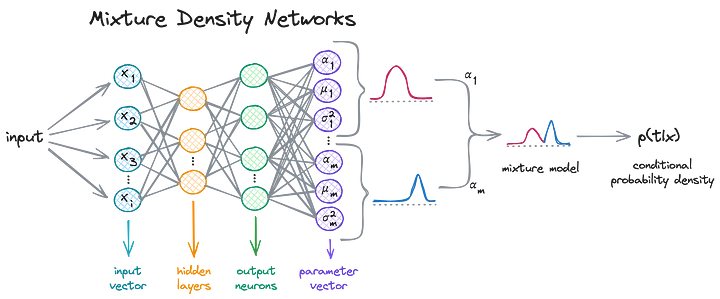

This project implements a suite of sequence modeling architectures to support probabilistic air quality forecasting using Mixture Density Networks (MDNs). Each model outputs parameters of a Gaussian mixture (μ, σ, α) for each time step, allowing for uncertainty-aware predictions.

1. **LSTM-MDN**
- Combines Long Short-Term Memory (LSTM) layers with an MDN head.
- Well-suited for capturing long-range temporal dependencies.
- Recommended for stable training on sequential air quality data.

2. **GRU-MDN**
- Uses Gated Recurrent Units (GRUs), which are computationally lighter than LSTMs.
- Offers comparable performance with fewer parameters and faster training.

3. **RNN-MDN**
- A vanilla recurrent neural network with an MDN output layer.
- Serves as a baseline for evaluating improvements from gated or attention-based models.
- Prone to vanishing gradients in long sequences.

4. **TCN-MDN (Temporal Convolutional Network)**
- Uses causal 1D convolutions and dilations instead of recurrence.
- Captures long-term patterns with high parallelism.
- Tends to overfit without proper regularization (e.g., dropout, weight decay).

5. **Transformer-MDN**
- Utilizes self-attention to learn dependencies across the entire input sequence.
- Best suited for longer sequences or when attention-based modeling is beneficial.
- Requires careful tuning and more compute.

In [ ]:
class MDNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_mixtures, dropout=0.0):
        super(MDNLayer, self).__init__()
        self.out_dim = out_dim
        self.num_mixtures = num_mixtures

        self.dropout = nn.Dropout(dropout)

        self.fc_mu = nn.Linear(in_dim, num_mixtures * out_dim)
        self.fc_sigma = nn.Linear(in_dim, num_mixtures * out_dim)
        self.fc_alpha = nn.Linear(in_dim, num_mixtures)

    def forward(self, x):
        x = self.dropout(x)
        mu = self.fc_mu(x)
        sigma = torch.exp(self.fc_sigma(x)).clamp(min=1e-6)  # ensures strictly positive
        alpha = F.softmax(self.fc_alpha(x), dim=1)
        return mu, sigma, alpha
    
    
class LSTM_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(LSTM_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # last timestep

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

In [ ]:
class GRU_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(GRU_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]  # Use last timestep

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

In [ ]:
class RNN_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures, output_dim, dropout=0.3):
        super(RNN_MDN, self).__init__()
        self.num_mixtures = num_mixtures
        self.hidden_dim = hidden_dim

        self.rnn = nn.RNN(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_output = rnn_out[:, -1, :]  # Last time step

        h = self.fc(last_output)
        h = self.batch_norm(h)
        h = F.relu(h)
        h = self.dropout(h)

        mu, sigma, alpha = self.mdn(h)
        return mu, sigma, alpha

In [ ]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size, padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class TCN_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_mixtures, output_dim, num_layers=4):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(
                TCNBlock(
                    in_channels=input_dim if i == 0 else hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=3,
                    dilation=2**i
                )
            )

        self.num_mixtures = num_mixtures
        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):  # x: (B, T, F)
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.tcn(x)
        x = self.global_pool(x).squeeze(-1)  # (B, hidden_dim)
        return self.mdn(x)

In [ ]:
class Transformer_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, num_mixtures, output_dim, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.input_norm = nn.LayerNorm(hidden_dim)
        self.input_dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.num_mixtures = num_mixtures
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_dropout = nn.Dropout(dropout)
        self.mdn = MDNLayer(hidden_dim, output_dim, num_mixtures)

    def forward(self, x):  # x: (B, T, F)
        x = self.input_proj(x)
        x = self.input_norm(x)
        x = self.input_dropout(x)

        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.output_dropout(x)

        mu, sigma, alpha = self.mdn(x)
        return mu, sigma, alpha

### Negative Log-Likelihood (NLL) Loss Function

Let:
- $ \mathbf{y} \in \mathbb{R}^D $ — target vector
- $ \boldsymbol{\mu}_k \in \mathbb{R}^D $ — mean vector of the $k$-th Gaussian
- $ \boldsymbol{\sigma}_k \in \mathbb{R}^D $ — standard deviation (scale) of the $k$-th Gaussian
- $ \alpha_k \in (0, 1) $ — mixture weight (prior probability) of the $k$-th Gaussian, where $ \sum_{k=1}^K \alpha_k = 1 $
- $ K $ — number of mixtures
- $ N $ — batch size

The mixture density network loss is the negative log-likelihood over a mixture of Gaussians:

$$ L_MDN = - (1 / N) * Σ_{i=1}^N log( Σ_{k=1}^K α_k^{(i)} * N(y^{(i)} | μ_k^{(i)}, σ_k^{(i)}) ) $$

Each Gaussian component with diagonal covariance is computed as:

$$ N(y | μ_k, σ_k) = Π_{d=1}^D [ 1 / sqrt(2πσ_{k,d}²) ] * exp( - (y_d - μ_{k,d})² / (2σ_{k,d}²) ) $$

Taking the logarithm of the Gaussian:

$$ log N(y | μ_k, σ_k) = - Σ_{d=1}^D [ (1/2) * log(2πσ_{k,d}²) + (y_d - μ_{k,d})² / (2σ_{k,d}²) ] $$ 

The final loss with log-sum-exp trick becomes:

$$ L_MDN = - (1 / N) * Σ_{i=1}^N log( Σ_{k=1}^K exp( log α_k^{(i)} + log N(y^{(i)} | μ_k^{(i)}, σ_k^{(i)}) ) ) $$ 

In [ ]:
def mdn_loss(y, mu, sigma, alpha, num_mixtures):
    batch_size = y.size(0)
    output_dim = mu.size(1) // num_mixtures

    mu = mu.view(batch_size, num_mixtures, output_dim)
    sigma = sigma.view(batch_size, num_mixtures, output_dim)
    alpha = alpha.view(batch_size, num_mixtures)

    y = y.unsqueeze(1).expand(-1, num_mixtures, -1)
    # print(f"y shape: {y.shape}, mu shape: {mu.shape}, sigma shape: {sigma.shape}, alpha shape: {alpha.shape}")
    # print("First pollutant over time (mu[:, 0, 0]):", mu[:, 0, 0])
    # print("All mixtures for time step 0 and pollutant 0 (mux[0, :, 0]):", mu[0, :, 0])
    # print("All pollutants at t=0, mixture=0 (mu[0, 0, :]):", mu[0, 0, :])

    # Gaussian log-likelihood per mixture
    normal = torch.distributions.Normal(loc=mu, scale=sigma)
    log_probs = normal.log_prob(y)  # [batch, num_mixtures, output_dim]
    log_probs = torch.sum(log_probs, dim=2)  # sum over output_dim

    # Weighted log likelihood
    weighted_log_probs = log_probs + torch.log(alpha + 1e-8)
    log_sum_exp = torch.logsumexp(weighted_log_probs, dim=1)
    return -torch.mean(log_sum_exp)

## Define our Custom Trainer Class

The Trainer class handles the training, validation, prediction, and checkpoint management of Mixture Density Network (MDN) models across various architectures (e.g., LSTM, GRU, RNN, TCN, Transformer) for air quality forecasting tasks.

In [ ]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 criterion,
                 optimizer,
                 train_dataset,
                 val_dataset=None,
                 model_pth: str = "model_checkpoint.pth",
                 batch_size: int = 256):
        """
        Initializes the training pipeline for a PyTorch model, including device configuration,
        data loading, and model checkpoint handling.

        Args:
            model (torch.nn.Module): The PyTorch model to be trained.
            criterion: The loss function used for training (e.g., nn.MSELoss, custom NLL).
            optimizer: The optimization algorithm (e.g., torch.optim.Adam).
            train_dataset (Dataset): The dataset used for training.
            val_dataset (Dataset, optional): The dataset used for validation. Defaults to None.
            model_pth (str, optional): Path to the model checkpoint file. Defaults to "model_checkpoint.pth".
            batch_size (int, optional): Batch size used for training and validation loaders. Defaults to 256.

        Attributes:
            device (torch.device): The device on which the model will be trained (MPS, CUDA, or CPU).
            model (torch.nn.Module): The model moved to the selected device.
            train_loader (DataLoader): DataLoader for the training dataset.
            val_loader (DataLoader or None): DataLoader for the validation dataset if provided.
            history (dict): Dictionary to store training history including loss and timing.
            start_epoch (int): The starting epoch index, updated if a checkpoint exists.
        """
        
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        if self.device == torch.device("cpu"):
            warnings.warn(
                "Running on CPU. Training may be slow. Consider using MPS or CUDA if available.",
            )

        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.model_pth = MODELS_DIR / model_pth

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'training_time': []
        }

        self.start_epoch = self.load(self.model_pth) if os.path.exists(self.model_pth) else 0

    def train(self, num_epochs=30):
        """
        Trains the model for a specified number of epochs using the provided training and
        validation datasets, loss function, and optimizer. Supports checkpointing and
        interruption handling.

        Args:
            num_epochs (int, optional): The total number of training epochs. 
                                        Training will resume from `self.start_epoch` if a checkpoint is found. Defaults to 30.

        Behavior:
            - Iterates over training data and computes the loss using the specified MDN loss function.
            - Performs backpropagation and optimization on each batch.
            - If a validation dataset is provided, evaluates the model after each epoch.
            - Tracks training and validation losses, and epoch durations in `self.history`.
            - Displays a progress bar with real-time loss reporting.
            - Saves a checkpoint and safely exits if interrupted (e.g., via Ctrl+C).

        Raises:
            KeyboardInterrupt: If training is manually interrupted, a checkpoint is saved and the exception is re-raised.
        """
        try:
            for epoch in (pbar:=tqdm(range(self.start_epoch, num_epochs))):
                start_time = time.time()
                self.model.train()
                train_loss = 0.0

                for inputs, targets in tqdm(self.train_loader, desc=f"Epoch {epoch+1}", unit="batch", disable=True):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
    
                    self.optimizer.zero_grad()
                    mu, sigma, alpha = self.model(inputs)
               
                    # print("Mu shape:", mu.shape)
                    # print(mu[:, 1])
                    loss = self.criterion(targets, mu, sigma, alpha, self.model.num_mixtures)
                    loss.backward()
                    self.optimizer.step()
                    train_loss += loss.detach().item()

                avg_train_loss = train_loss / len(self.train_loader)
                self.history['train_loss'].append(avg_train_loss)

                if self.val_loader:
                    self.model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for inputs, targets in tqdm(self.val_loader, desc="Validation", unit="batch", disable=True):
                            inputs = inputs.to(self.device)
                            targets = targets.to(self.device)

                            mu, sigma, alpha = self.model(inputs)
                            loss = self.criterion(targets, mu, sigma, alpha, self.model.num_mixtures)
                            
                            val_loss += loss.item()

                    avg_val_loss = val_loss / len(self.val_loader)
                    self.history['val_loss'].append(avg_val_loss)

                    pbar.set_description(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")
                else:
                    pbar.set_description(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}")

                self.history['training_time'].append(time.time() - start_time)

        except KeyboardInterrupt as e:
            print("\n🛑 Training interrupted by user. Saving checkpoint...")
            self.save(epoch + 1)
            raise KeyboardInterrupt from e

    def predict_from_val(self, indices: list[int]):
        """
        Generates predictions from specific samples in the validation dataset using a trained
        Mixture Density Network (MDN) model. Computes the expected value of the predicted 
        mixture distribution and retrieves metadata for interpretability.

        Args:
            indices (list[int]): List of sample indices from the validation dataset to evaluate.

        Returns:
            dict: A dictionary containing:
                - "predictions" (np.ndarray): Expected values computed from the MDN outputs.
                - "ground_truths" (np.ndarray): True target values for the selected indices.
                - "mus" (np.ndarray): Mixture component means predicted by the MDN.
                - "sigmas" (np.ndarray): Mixture component standard deviations predicted by the MDN.
                - "alphas" (np.ndarray): Mixture weights (probabilities) for each Gaussian component.
                - "timestamps" (np.ndarray): Timestamps corresponding to each data point, from metadata.
                - "unnormalized_targets" (np.ndarray): Original target values before normalization.
                - "means" (np.ndarray): Mean values used for normalization of each data point.
                - "stds" (np.ndarray): Standard deviations used for normalization of each data point.

        Raises:
            ValueError: If the validation dataset is not provided during initialization.

        Notes:
            - This method sets the model to evaluation mode (`model.eval()`).
            - The MDN output is decomposed into μ, σ, and α, and the expected value is calculated.
            - Metadata retrieval assumes the dataset implements a `get_metadata(index)` method.
        """
        if self.val_loader is None:
            raise ValueError("Validation dataset not provided.")

        self.model.eval()
        filtered_data = [self.val_dataset[i] for i in indices]
        data_loader = DataLoader(filtered_data, batch_size=1, shuffle=False)

        predictions = []
        ground_truths = []
        mus, sigmas, alphas = [], [], []
        timestamps = []
        original_targets = []
        means = []
        stds = []

        with torch.no_grad():
            for i, (inputs, targets) in zip(indices, data_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                mu, sigma, alpha = self.model(inputs)

                batch_size = inputs.shape[0]
                num_mixtures = self.model.num_mixtures
                output_dim = mu.shape[1] // num_mixtures

                mu = mu.view(batch_size, num_mixtures, output_dim)
                sigma = sigma.view(batch_size, num_mixtures, output_dim)
                alpha = alpha.view(batch_size, num_mixtures)

                pred = torch.sum(mu * alpha.unsqueeze(-1), dim=1)

                predictions.append(pred.squeeze(0).cpu().numpy())
                ground_truths.append(targets.squeeze(0).cpu().numpy())
                mus.append(mu.squeeze(0).cpu().numpy())
                sigmas.append(sigma.squeeze(0).cpu().numpy())
                alphas.append(alpha.squeeze(0).cpu().numpy())

                # Retrieve metadata using index
                meta = self.val_dataset.get_metadata(i)
                timestamps.append(meta["timestamp"])
                original_targets.append(meta["original_target"])
                means.append(meta["mean"])
                stds.append(meta["std"])

        return {
            "predictions": np.array(predictions),
            "ground_truths": np.array(ground_truths),
            "mus": np.array(mus),
            "sigmas": np.array(sigmas),
            "alphas": np.array(alphas),
            "timestamps": np.array(timestamps),
            "unnormalized_targets": np.array(original_targets),
            "means": np.array(means),
            "stds": np.array(stds),
            
        }

    def save(self, epoch=None):
        """
        Saves the current state of the model, optimizer, and training history to disk.

        Args:
            epoch (int, optional): The training epoch to record. If not provided, it defaults
            to the current length of the training loss history.

        Saves:
            A dictionary containing:
                - 'model_state_dict': Current weights of the model.
                - 'optimizer_state_dict': Current state of the optimizer.
                - 'history': Training and validation loss history.
                - 'epoch': The epoch number at the time of saving.

        Effects:
            - Serializes the checkpoint to `self.model_pth` using `torch.save`.
            - Prints a confirmation message indicating the file path and epoch.

        """
        if epoch is None:
            epoch = len(self.history['train_loss'])

        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'epoch': epoch,
        }, self.model_pth)
        print(f"✅ Saved model to {self.model_pth} at epoch {epoch}")

    def load(self, path):
        """
        Loads a saved model checkpoint from the specified file path.

        Args:
            path (str): Path to the saved checkpoint file.

        Loads:
            - 'model_state_dict': Restores the model weights.
            - 'optimizer_state_dict': Restores the optimizer state.
            - 'history': Restores the training history (if available).
            - 'epoch': The epoch at which the checkpoint was saved.

        Returns:
            int: The epoch number stored in the checkpoint. Defaults to 0 if not found.

        Effects:
            - Loads the model and optimizer states into the current instance.
            - Updates the training history if present in the checkpoint.
            - Prints a confirmation message with the path and epoch number.

        """
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint.get('history', self.history)
        print(f"✅ Loaded checkpoint from '{path}' (epoch {checkpoint.get('epoch', 0)})")
        return checkpoint.get('epoch', 0)

## Hyperparameter Tuning

To optimize the performance of all models utilizing Mixture Density Network (LSTM-MDN), we implemented a systematic hyperparameter search using Optuna. This approach allows efficient exploration of the hyperparameter space to minimize the model’s negative log-likelihood (NLL) on the validation set.

In [ ]:
def lstm_mdn_objective(trial):
    try:
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 1, 3)
        num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
        learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
        step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
        dropout = trial.suggest_float("dropout", 0.0, 0.5)

        lookback_hours = lookback_days * 24

        training_dataset, validation_dataset = generate_datasets(
            dataset_df,
            lookback=lookback_hours,
            delay=24,   # predict 1 day ahead (constant)
            step=step
        )

        model = LSTM_MDN(
            input_dim=21,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_mixtures=num_mixtures,
            output_dim=7,
            dropout=dropout
            # fc_dim=fc_dim
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        param_str = json.dumps(trial.params, sort_keys=True)
        param_hash = hashlib.md5(param_str.encode()).hexdigest()
        model_pth = f"transformer_mdn_{param_hash}_checkpoint.pth"
        trainer = Trainer(
            model=model,
            criterion=mdn_loss,
            optimizer=optimizer,
            train_dataset=training_dataset,
            val_dataset=validation_dataset,
            model_pth=model_pth,
            batch_size=256
        )

        trainer.train(num_epochs=30)

        return trainer.history['val_loss'][-1]

    except KeyboardInterrupt as e:
        raise KeyboardInterrupt from e
    except Exception as e:
        print(f"Error during trial {trial.number}: {e}")
        return float("inf")

lstm_study = optuna.create_study(
    direction="minimize",  # because lower NLL is better
    study_name="lstm_mdn_hyperparam_search",
    storage=f"sqlite:///{MODELS_DIR}/optuna_study.db",
    load_if_exists=True
)
if ENABLE_TRAINING:
    lstm_study.optimize(lstm_mdn_objective, n_trials=30)

In [ ]:
def gru_mdn_objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
    step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    lookback_hours = lookback_days * 24

    training_dataset, validation_dataset = generate_datasets(
        dataset_df,
        lookback=lookback_hours,
        delay=24,  # 1-day ahead prediction
        step=step
    )

    model = GRU_MDN(
        input_dim=21,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_mixtures=num_mixtures,
        output_dim=7,
        dropout=dropout
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    param_str = json.dumps(trial.params, sort_keys=True)
    param_hash = hashlib.md5(param_str.encode()).hexdigest()
    model_pth = f"transformer_mdn_{param_hash}_checkpoint.pth"
    trainer = Trainer(
        model=model,
        criterion=mdn_loss,
        optimizer=optimizer,
        train_dataset=training_dataset,
        val_dataset=validation_dataset,
        model_pth=model_pth,
        batch_size=256
    )

    trainer.train(num_epochs=30)

    return trainer.history['val_loss'][-1]

gru_study = optuna.create_study(
    direction="minimize",
    study_name="gru_mdn_hyperparam_search",
    storage=f"sqlite:///{MODELS_DIR}/optuna_study.db",
    load_if_exists=True
)

if ENABLE_TRAINING:
    gru_study.optimize(gru_mdn_objective, n_trials=30)


In [ ]:
def rnn_mdn_objective(trial):
    try:
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 1, 3)
        num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
        learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
        step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])  # hours between timesteps
        dropout = trial.suggest_float("dropout", 0.0, 0.5)

        lookback_hours = lookback_days * 24

        training_dataset, validation_dataset = generate_datasets(
            dataset_df,
            lookback=lookback_hours,
            delay=24,  # 1-day ahead forecast
            step=step
        )

        model = RNN_MDN(
            input_dim=21,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_mixtures=num_mixtures,
            output_dim=7,
            dropout=dropout
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        param_str = json.dumps(trial.params, sort_keys=True)
        param_hash = hashlib.md5(param_str.encode()).hexdigest()
        model_pth = f"transformer_mdn_{param_hash}_checkpoint.pth"
        
        trainer = Trainer(
            model=model,
            criterion=mdn_loss,
            optimizer=optimizer,
            train_dataset=training_dataset,
            val_dataset=validation_dataset,
            model_pth=model_pth,
            batch_size=256
        )

        trainer.train(num_epochs=30)

        return trainer.history['val_loss'][-1]
    except KeyboardInterrupt as e:
        raise KeyboardInterrupt from e
    except Exception as e:
        print(f"Error during trial {trial.number}: {e}")
        return float("inf")

rnn_study = optuna.create_study(
    direction="minimize",
    study_name="rnn_mdn_hyperparam_search",
    storage=f"sqlite:///{MODELS_DIR}/optuna_study.db",
    load_if_exists=True
)

if ENABLE_TRAINING:
    rnn_study.optimize(rnn_mdn_objective, n_trials=30)

In [ ]:
def tcn_mdn_objective(trial):
    try:
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 2, 5)
        num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
        learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
        step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])
        dropout = trial.suggest_float("dropout", 0.0, 0.5)

        lookback_hours = lookback_days * 24

        training_dataset, validation_dataset = generate_datasets(
            dataset_df,
            lookback=lookback_hours,
            delay=24,  # 1-day ahead prediction
            step=step
        )

        model = TCN_MDN(
            input_dim=21,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_mixtures=num_mixtures,
            output_dim=7,
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        param_str = json.dumps(trial.params, sort_keys=True)
        param_hash = hashlib.md5(param_str.encode()).hexdigest()
        model_pth = f"transformer_mdn_{param_hash}_checkpoint.pth"
        trainer = Trainer(
            model=model,
            criterion=mdn_loss,
            optimizer=optimizer,
            train_dataset=training_dataset,
            val_dataset=validation_dataset,
            model_pth=model_pth,
            batch_size=256
        )

        trainer.train(num_epochs=30)

        return trainer.history['val_loss'][-1]
    except KeyboardInterrupt as e:
        raise KeyboardInterrupt from e
    except Exception as e:
        print(f"Error during trial {trial.number}: {e}")
        return float("inf")
    
tcn_study = optuna.create_study(
    direction="minimize",
    study_name="tcn_mdn_hyperparam_search",
    storage=f"sqlite:///{MODELS_DIR}/optuna_study.db",
    load_if_exists=True
)


if ENABLE_TRAINING:
    tcn_study.optimize(tcn_mdn_objective, n_trials=30)

In [ ]:
def transformer_mdn_objective(trial):
    try:
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 1, 4)
        num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
        num_mixtures = trial.suggest_int("num_mixtures", 3, 8)
        learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        dropout = trial.suggest_float("dropout", 0.0, 0.5)
        lookback_days = trial.suggest_categorical("lookback_days", [1, 2, 4])
        step = trial.suggest_categorical("step", [1, 2, 3, 4, 6])

        lookback_hours = lookback_days * 24

        training_dataset, validation_dataset = generate_datasets(
            dataset_df,
            lookback=lookback_hours,
            delay=24,  # predict 1 day ahead
            step=step
        )

        model = Transformer_MDN(
            input_dim=21,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            num_mixtures=num_mixtures,
            output_dim=7,
            dropout=dropout
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        param_str = json.dumps(trial.params, sort_keys=True)
        param_hash = hashlib.md5(param_str.encode()).hexdigest()
        model_pth = f"transformer_mdn_{param_hash}_checkpoint.pth"

        trainer = Trainer(
            model=model,
            criterion=mdn_loss,
            optimizer=optimizer,
            train_dataset=training_dataset,
            val_dataset=validation_dataset,
            model_pth=model_pth,
            batch_size=256
        )

        trainer.train(num_epochs=30)

        return trainer.history['val_loss'][-1]
    except KeyboardInterrupt as e:
        raise KeyboardInterrupt from e
    except Exception as e:
        print(f"Error during trial {trial.number}: {e}")
        return float("inf")
    
transformer_study = optuna.create_study(
    direction="minimize",
    study_name="transformer_mdn_hyperparam_search",
    storage=f"sqlite:///{MODELS_DIR}/optuna_study.db",
    load_if_exists=True
)

if ENABLE_TRAINING:
    transformer_study.optimize(transformer_mdn_objective, n_trials=30)

## Visualizing Results

The `MDNVisualizer` provides diagnostic and interpretative visualizations for models trained with Mixture Density Networks (MDNs). It is designed to work with a Trainer object and supports time series plotting, distribution visualization, animated evolution, and statistical summaries.

In [ ]:
class MDNVisualizer:
    def __init__(self, trainer: Trainer):
        self.trainer = trainer

    def plot_timeseries_from_val(self, indeces, num_targets=None, title=None):
        results = self.trainer.predict_from_val(indeces)
        predictions = results["predictions"]
        ground_truths = results["ground_truths"]
        mus = results["mus"]
        sigmas = results["sigmas"]
        alphas = results["alphas"]
        timestamps = results["timestamps"]
        unnormalized_targets = results["unnormalized_targets"]
        means = results["means"]
        stds = results["stds"]

        x = np.array(timestamps)

        if num_targets is None:
            num_targets = len(POLLUTANT_COLUMNS)
        num_mixtures = mus.shape[1]

        # Grid config: 2 columns
        ncols = 2
        nrows = math.ceil(num_targets / ncols)
        fig, axs = plt.subplots(nrows, ncols, figsize=(14, 5.5 * nrows), sharex=True)
        axs = axs.flatten()

        for target_idx in range(num_targets):
            ax = axs[target_idx]

            y_pred_norm = predictions[:, target_idx]
            y_true = unnormalized_targets[:, target_idx]

            mu = mus[:, :, target_idx]
            sigma = sigmas[:, :, target_idx]
            alpha = alphas

            mixture_var = np.sum(alpha * (sigma**2 + mu**2), axis=1) - np.sum(alpha * mu, axis=1)**2
            mixture_std = np.sqrt(np.clip(mixture_var, 1e-8, None))

            mean = means[0][target_idx]
            std = stds[0][target_idx]

            y_pred = y_pred_norm * std + mean
            mixture_std_scaled = mixture_std * std
            mu_scaled = mu * std + mean

            z_90 = 1.645
            z_95 = 1.960

            ax.plot(x, y_true, label="Ground Truth", color="black", linewidth=2)
            ax.plot(x, y_pred, label="Prediction (E[y])", color="blue", linestyle="--")

            # 90% CI (clip lower bound to 0)
            ax.fill_between(
                x,
                np.clip(y_pred - z_90 * mixture_std_scaled, a_min=0, a_max=None),
                y_pred + z_90 * mixture_std_scaled,
                color='blue', alpha=0.12, label="90% CI"
            )

            # 95% CI (clip lower bound to 0)
            ax.fill_between(
                x,
                np.clip(y_pred - z_95 * mixture_std_scaled, a_min=0, a_max=None),
                y_pred + z_95 * mixture_std_scaled,
                color='blue', alpha=0.07, label="95% CI"
            )

            ax.set_title(f"{POLLUTANT_COLUMNS[target_idx].replace('components.', '').replace('_','.').upper()} Forecast")
            ax.set_ylabel("Concentration (ug/m³)")
            ax.grid(True)

        # Remove unused subplots
        for i in range(num_targets, len(axs)):
            fig.delaxes(axs[i])

        # axs[-1].set_xlabel("Timestamp")
        if title:
            plt.suptitle(title, fontsize=16)
      
        fig.legend(
                *axs[0].get_legend_handles_labels(),
                loc="upper right",
                ncol=2
                # bbox_to_anchor=(0.82, 0.08),
                # frameon=False,
            )
        plt.tight_layout()
        # plt.show()

    def plot_mixture_distributions_at_timestep(self, timestep_index: int, num_targets=None, save_path=None):
        result = self.trainer.predict_from_val([timestep_index])

        mus = result["mus"][0]
        sigmas = result["sigmas"][0]
        alphas = result["alphas"][0]
        means = result["means"][0]
        stds = result["stds"][0]
        timestamp = result["timestamps"][0]

        if num_targets is None:
            num_mixtures, num_targets = mus.shape
        else:
            num_mixtures = mus.shape[0]
        ncols = 2
        nrows = math.ceil(num_targets / ncols)

        fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows), sharex=False)
        
        # fig.suptitle("Mixture Distributions", fontsize=16)
        axs = axs.flatten()

        mixture_line = None
        sum_line = None
        

        for target_idx in range(num_targets):
            ax = axs[target_idx]

            mu = mus[:, target_idx]
            sigma = sigmas[:, target_idx]
            alpha = alphas

            mean = means[target_idx]
            std = stds[target_idx]

            mu_scaled = mu * std + mean
            sigma_scaled = sigma * std
            x_range = np.linspace(-5, 5, 1000)
            x_scaled = x_range * std + mean

            total_pdf = np.zeros_like(x_scaled)

            for k in range(num_mixtures):
                pdf = alpha[k] * norm.pdf(x_scaled, loc=mu_scaled[k], scale=sigma_scaled[k])
                total_pdf += pdf

                # Save the first mixture line for the legend
                line = ax.plot(x_scaled, pdf, linestyle="--", alpha=0.6)
                if target_idx == 0 and k == 0:
                    mixture_line = line[0]

            # Plot the combined mixture sum
            line = ax.plot(x_scaled, total_pdf, color="black", linewidth=2)
            if target_idx == 0:
                sum_line = line[0]

            mu_center = np.sum(mu_scaled * alpha)
            std_combined = np.sqrt(np.sum(alpha * sigma_scaled**2))
            ax.set_xlim(mu_center - 4 * std_combined, mu_center + 4 * std_combined)
            ax.set_xlabel("Concentration (mg/m³)")
            ax.set_title(f"{POLLUTANT_COLUMNS[target_idx]}".replace("components.", "").replace("_", ".").upper())
            ax.set_ylabel("Density")
            ax.grid(True)

        for idx in range(num_targets, len(axs)):
            fig.delaxes(axs[idx])

       
        if mixture_line and sum_line:
            fig.legend(
                handles=[mixture_line, sum_line],
                labels=["Mixtures", "Mixture Sum"],
                loc="upper right",
                # bbox_to_anchor=(0.93, 0.15),
                frameon=False,
                ncols=2,
            )

        fig.suptitle(
            f"Mixture Distributions",
            fontsize=16, fontweight='bold',
            # ha='right', va='bottom'
        )

        fig.text(
            0.1, 0.90, f"{timestamp.strftime('%-I %p')}",
            fontsize=12, fontweight='bold',
            ha='right', va='bottom'
        )


        if save_path:
            fig.savefig(save_path, bbox_inches="tight")
            plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()

    def generate_mixture_gif(self, start: int, end: int, num_targets :int ,  output_path: str = "mixture_evolution.gif"):
        frame_paths = []
        for t in tqdm(range(start, end), desc="Generating frames", disable=TQDM_DISABLE):
            frame_file = OUTPUT_DIR / f"frame_{t:03d}.png"
            self.plot_mixture_distributions_at_timestep(timestep_index=t, num_targets=num_targets, save_path=frame_file)
            frame_paths.append(frame_file)

        base_size = Image.open(frame_paths[0]).size
        images = [Image.open(fp).resize(base_size) for fp in frame_paths]
        imageio.mimsave(OUTPUT_DIR/output_path, images, duration=0.8)

        for fp in frame_paths:
            os.remove(fp)

        print(f"GIF saved to: {output_path}")

    def generate_insights_from_timestep(self, timestep_index):
        result = self.trainer.predict_from_val([timestep_index])

        mus = result["mus"][0]          # (num_mixtures, num_targets)
        sigmas = result["sigmas"][0]    # (num_mixtures, num_targets)
        alphas = result["alphas"][0]    # (num_mixtures,)
        means = result["means"][0]      # (num_targets,)
        stds = result["stds"][0]        # (num_targets,)
        timestamp = result["timestamps"][0]  # datetime

        num_mixtures, num_targets = mus.shape

        expected_values = []
        ci_90_bounds = []
        ci_95_bounds = []

        for t in range(num_targets):
            mu = mus[:, t] * stds[t] + means[t]
            sigma = sigmas[:, t] * stds[t]
            alpha = alphas

            expected = np.sum(alpha * mu)
            expected_values.append(expected)

            mixture_var = np.sum(alpha * (sigma**2 + mu**2)) - expected**2
            std_dev = np.sqrt(mixture_var)

            z90 = norm.ppf(0.95)
            z95 = norm.ppf(0.975)

            ci_90 = (
                max(0, expected - z90 * std_dev),
                expected + z90 * std_dev
            )

            ci_95 = (
                max(0, expected - z95 * std_dev),
                expected + z95 * std_dev
            )

            ci_90_bounds.append(ci_90)
            ci_95_bounds.append(ci_95)

        mus_unnorm = mus * stds[None, :] + means[None, :]
        sigmas_unnorm = sigmas * stds[None, :]

        timestamp_str = timestamp.strftime("%B %d, %Y at %-I:%M %p") if hasattr(timestamp, "strftime") else str(timestamp)
        report_lines = []

        for i in range(num_targets):
            pollutant = POLLUTANT_COLUMNS[i].replace("components.", "").replace("_", ".").upper()
            expected = expected_values[i]
            ci90_lower, ci90_upper = ci_90_bounds[i]
            ci95_lower, ci95_upper = ci_95_bounds[i]

            report = (
                f"At {timestamp_str}, the expected concentration of {pollutant} was estimated at "
                f"{expected:.2f} ug/m³.\n"
                f"We are 90% confident that the true value lies between {ci90_lower:.2f} and {ci90_upper:.2f} mg/m³,\n"
                f"and 95% confident it lies between {ci95_lower:.2f} and {ci95_upper:.2f} mg/m³.\n"
            )
            report_lines.append(report)

        return {
            "timestamp": timestamp,
            "expected_values": expected_values,
            "mixtures": {
                "mu": mus_unnorm,
                "sigma": sigmas_unnorm,
                "alpha": alphas
            },
            "ci_90": ci_90_bounds,
            "ci_95": ci_95_bounds,
            "text_report": report_lines
        }

In [ ]:
def plot_model_performance(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # Add a third subplot
    fig.suptitle(f'{trainer.model.__class__.__name__} Training History', fontsize=12)

    # Add text annotations for the last epoch's accuracy
    last_epoch = len(trainer.history['train_loss']) - 1
    train_acc_last = trainer.history['train_loss'][last_epoch]
    val_acc_last = trainer.history['val_loss'][last_epoch]
    ax[0].text(0.5, 0.7, f'Last Train Loss: {train_acc_last:.2f}', transform=ax[0].transAxes, fontsize=10, ha='center', color='blue')
    ax[0].text(0.5, 0.75, f'Last Val Loss: {val_acc_last:.2f}', transform=ax[0].transAxes, fontsize=10, ha='center', color='orange')

    # Plot loss
    ax[0].plot(trainer.history['train_loss'], label='Train')
    ax[0].plot(trainer.history['val_loss'], label='Validation')
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')

    # Plot training time
    ax[1].plot(trainer.history['training_time'], label='Training Time')
    ax[1].set_title('Training Time per Epoch')
    ax[1].set_ylabel('Time (seconds)')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    # Calculate average and total training time
    avg_time = sum(trainer.history['training_time']) / len(trainer.history['training_time'])
    total_time = sum(trainer.history['training_time'])

    # Add text annotations for average and total training time
    ax[1].text(0.5, 0.1, f'Avg Time: {avg_time:.2f}s', transform=ax[1].transAxes, fontsize=10, ha='center', color='black')
    ax[1].text(0.5, 0.05, f'Total Time: {total_time:.2f}s', transform=ax[1].transAxes, fontsize=10, ha='center', color='black')

    # plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

def compare_model_performance(*trainers):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Model Performance Comparison', fontsize=13)
    
    for trainer in trainers:
        
        ax[0].plot(trainer.history['train_loss'], label=trainer.model.__class__.__name__)
        ax[1].plot(trainer.history['val_loss'], label=trainer.model.__class__.__name__)

    

    ax[0].set_title('Train Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='upper left')

    ax[1].set_title('Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper left')

    plt.tight_layout()

In [ ]:
params = lstm_study.best_params

model = LSTM_MDN(
    input_dim=21, # Number of features (21 including city dummies)
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    num_mixtures=params['num_mixtures'],
    output_dim=7, # Number of pollutants
    dropout=params['dropout']
)

training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=params['lookback_days']*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=params['step']      # Any values will do
)
    
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

loss = mdn_loss
lstm_trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="best_lstm_model.pth",
    batch_size=256
)

if ENABLE_TRAINING:
    lstm_trainer.train(num_epochs=30)
    lstm_trainer.save()

In [ ]:
params = gru_study.best_params
model = GRU_MDN(
    input_dim=21,  # Number of features (21 including city dummies)
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    num_mixtures=params['num_mixtures'],
    output_dim=7,  # Number of pollutants
    dropout=params['dropout']
)
training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=params['lookback_days']*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=params['step']      # Any values will do
)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
gru_trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="best_gru_model.pth",
    batch_size=256
)
if ENABLE_TRAINING:
    gru_trainer.train(num_epochs=30)
    gru_trainer.save()

In [ ]:
params = rnn_study.best_params
model = RNN_MDN(
    input_dim=21,  # Number of features (21 including city dummies)
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    num_mixtures=params['num_mixtures'],
    output_dim=7,  # Number of pollutants
    dropout=params['dropout']
)
training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=params['lookback_days']*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=params['step']      # Any values will do
)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
rnn_trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="best_rnn_model.pth",
    batch_size=256
)
if ENABLE_TRAINING:
    rnn_trainer.train(num_epochs=30)
    rnn_trainer.save()

In [ ]:
!rm /mnt/processed/private/msds2025/cpt3/ml3/finalproject/weights/best_tcn_model.pth

In [ ]:
params = tcn_study.best_params
model = TCN_MDN(
    input_dim=21,  # Number of features (21 including city dummies)
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    num_mixtures=params['num_mixtures'],
    output_dim=7,  # Number of pollutants
)
training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=params['lookback_days']*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=params['step']      # Any values will do
)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
tcn_trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="best_tcn_model.pth",
    batch_size=256
)
if ENABLE_TRAINING:
    tcn_trainer.train(num_epochs=30)
    tcn_trainer.save()

In [ ]:
params = transformer_study.best_params

model = Transformer_MDN(
    input_dim=21, # Number of features (21 including city dummies)
    hidden_dim=params['hidden_dim'],
    num_layers=params['num_layers'],
    num_heads=params['num_heads'],
    num_mixtures=params['num_mixtures'],
    output_dim=7, # Number of pollutants
    # fc_dim=128
    dropout=params['dropout']
)

training_dataset, validation_dataset = generate_datasets(
    dataset_df,
    lookback=params['lookback_days']*24,  # Hyperparameter tunable only on number of hours (4 days)
    delay=24,    # Constant (Not hyperparamter tunable). Predicting 1 day ahead
    step=params['step']      # Any values will do
)
    
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

loss = mdn_loss
transformer_trainer = Trainer(
    model=model,
    criterion=loss,
    optimizer=optimizer,
    train_dataset=training_dataset,
    val_dataset=validation_dataset,
    model_pth="best_mdn_model.pth",
    batch_size=256
)

if ENABLE_TRAINING:
    transformer_trainer.train(num_epochs=30)
    transformer_trainer.save()

## Results

In [ ]:
best_results_df = pd.DataFrame({
    "Model": [
        "LSTM-MDN",
        "GRU-MDN",
        "RNN-MDN",
        "TCN-MDN",
        "Transformer-MDN"
    ],
    "Training Loss": [
        lstm_trainer.history['train_loss'][-1],
        gru_trainer.history['train_loss'][-1],
        rnn_trainer.history['train_loss'][-1],
        tcn_trainer.history['train_loss'][-1],
        transformer_trainer.history['train_loss'][-1]
    ],
    "Validation Loss": [
        lstm_trainer.history['val_loss'][-1],
        gru_trainer.history['val_loss'][-1],
        rnn_trainer.history['val_loss'][-1],
        tcn_trainer.history['val_loss'][-1],
        transformer_trainer.history['val_loss'][-1]
    ],
    "Training Time per Epoch (s)": [
        np.average(lstm_trainer.history['training_time']),
        np.average(gru_trainer.history['training_time']),
        np.average(rnn_trainer.history['training_time']),
        np.average(tcn_trainer.history['training_time']),
        np.average(transformer_trainer.history['training_time'])
    ]
})
best_results_df

In [ ]:
compare_model_performance(rnn_trainer, gru_trainer, lstm_trainer, tcn_trainer, transformer_trainer)

The training and validation loss curves in the figure above reveal key differences in how each model learns and generalizes over time. Both **GRU-MDN and RNN-MDN** demonstrate stable and effective convergence, with validation losses steadily decreasing and closely tracking their training losses—indicating strong generalization and minimal overfitting. In contrast, TCN-MDN exhibits the lowest training loss among all models, but this comes at the cost of a rapidly diverging validation loss after approximately 10 epochs. This behavior clearly signals severe overfitting, confirming the model’s inability to generalize beyond the training set. 

Meanwhile, Transformer-MDN shows signs of underfitting, characterized by slow loss reduction and early plateauing in both training and validation curves. This suggests that the model’s complexity may not be fully utilized given the dataset size or sequence length. 

Finally, LSTM-MDN performs competitively but shows slight fluctuations in validation loss in the later epochs, hinting at sensitivity to optimization dynamics or hyperparameter settings. Overall, GRU-MDN offers the most balanced performance in terms of convergence speed, generalization, and training stability.

In [ ]:
visualizer = MDNVisualizer(gru_trainer)
visualizer.plot_timeseries_from_val(indeces=range(100, 250), num_targets=2, title="GRU-MDN Forecast for CO and NO")

Analysis of the forecast plots for CO and NO reveals that the model captures the temporal alignment of pollution peaks with high fidelity. However, the predicted expected values tend to underestimate the magnitude of extreme events, particularly visible in the CO forecast. Despite this, the model’s confidence intervals often enclose the ground truth, demonstrating that the MDN correctly conveys uncertainty through its probabilistic outputs.

Furthermore, the model adapts its uncertainty estimates to the volatility of the signal: intervals narrow during stable periods and widen during peaks or transitions, which aligns with the expected behavior of aleatoric uncertainty modeling.

In [ ]:
_ = visualizer.generate_insights_from_timestep(timestep_index=228)

In [ ]:
visualizer.plot_mixture_distributions_at_timestep(
    timestep_index=228, num_targets=7, 
)

The confidence intervals successfully cover the majority of the true values, especially during high-volatility periods, suggesting that the MDN’s variance estimates (σ) appropriately scale with data uncertainty. During relatively stable periods, the intervals tighten, indicating low predicted uncertainty, whereas during sharp peaks or transitions, the intervals expand, reflecting higher uncertainty in the model’s forecast.

In [ ]:
visualizer.generate_mixture_gif(
    start=100, end=250, num_targets=2,
    output_path="mixture_evolution.gif")

## Conclusions

Among the five architectures evaluated, GRU-MDN achieved the best performance with the lowest validation loss of –4.73, indicating strong generalization capability. LSTM-MDN and RNN-MDN followed closely behind with similar training and validation losses, suggesting stable learning and good fit.

In contrast, TCN-MDN exhibited the lowest training loss (–7.23) but a dramatically higher validation loss (–0.38), indicating significant overfitting — the model memorized the training data but failed to generalize. Meanwhile, Transformer-MDN had the highest training time per epoch (~11s) but did not outperform simpler models, possibly due to overparameterization or insufficient sequence length for attention mechanisms to shine.

Overall, GRU-MDN offers the best trade-off between accuracy and training efficiency for this task. Further improvements could explore regularization techniques for TCN or architecture tuning for Transformer to mitigate underperformance and overfitting.


## Recommendations

Based on the results, several improvements can be made to both the modeling approach and the use of Mixture Density Networks (MDNs). Since GRU-MDN yielded the best validation performance, it would be beneficial to further explore deeper or wider GRU architectures, balancing model capacity with overfitting risk. The TCN-MDN model suffered from severe overfitting; introducing dropout layers, weight decay, or early stopping may help control this. The Transformer-MDN, while expressive, did not outperform simpler models and incurred the highest training time. It may benefit from architectural simplification, such as reducing the number of layers or attention heads, and from tuning positional encodings more suited to time series data.

For MDNs specifically, one recommendation is to clamp or regularize the predicted standard deviation \sigma to prevent the model from becoming overconfident and numerically unstable. This can be done using techniques like exponential transformations followed by a minimum clamp value. Another concern is mixture collapse, where one or two components dominate the mixture. This can be mitigated by softening the softmax temperature or adding a loss penalty that promotes component diversity. It is also important to perform visual diagnostics of the predicted distributions, particularly in scenarios where multi-modal predictions are expected — this highlights where MDNs are most valuable.

MDNs can serve as strong uncertainty-aware forecasting baselines and should be compared with other probabilistic modeling approaches suach as Deep Ensembles, Bayesian Neural Networks, Variational Autoencoders, and Quantile Regression.

## Declaration on the Use of Large Language Models (LLMs)

This notebook and its accompanying Python code were developed with the support of large language models (LLMs), particularly OpenAI’s ChatGPT, which assisted in several key areas:

Content Refinement:
- Enhanced the clarity and coherence of technical explanations.
- Suggested alternative phrasing and structural adjustments to improve readability.

Code Assistance:
- Provided guidance on algorithm selection and Python code implementation.
- Offered suggestions for debugging and code optimization.

While LLMs were used to augment productivity, all content and code were thoroughly reviewed, validated, and adjusted to ensure technical correctness, contextual relevance, and ethical integrity. The authors accept full responsibility for the final content, methods, and findings presented in this notebook.

